# Importing Libraries and Data

In [106]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

In [38]:
# Reading in the data
mosquito_train = pd.read_csv('./assets/mosquito_train', index_col=0)
mosquito_test = pd.read_csv('./assets/mosquito_test', index_col=0)
weather_train = pd.read_csv('./assets/weather_train', index_col=0)
weather_test = pd.read_csv('./assets/weather_test', index_col=0)

In [39]:
# Converting the date time data back into date time objects
mosquito_train['TEST DATE'] = pd.to_datetime(mosquito_train['TEST DATE'].map(lambda x: x[:10]))
mosquito_test['TEST DATE'] = pd.to_datetime(mosquito_test['TEST DATE'].map(lambda x: x[:10]))
weather_train.index = pd.DatetimeIndex(weather_train.index)
weather_test.index = pd.DatetimeIndex(weather_test.index)

# Merging the Data

In [40]:
weather_train.reset_index(inplace=True)
weather_test.reset_index(inplace=True)
train = pd.merge(mosquito_train, weather_train, left_on='TEST DATE', right_on='DATE', how='left')
train.set_index('TEST DATE', inplace=True)
test = pd.merge(mosquito_test, weather_test, left_on='TEST DATE', right_on='DATE', how='left')
test.set_index('TEST DATE', inplace=True)

# Modeling
### Getting the data frames ready

In [41]:
# Setting the result to be found west nile virus or did not find it
train['RESULT'] = train['RESULT'].map(lambda x: 1 if x >= 1 else 0)
test['RESULT'] = test['RESULT'].map(lambda x: 1 if x >= 1 else 0)

In [42]:
# Splitting up the data with model features
model_features = ['DW_1', 'DW_2', 'DW_3', 'DW_4', 'DW_5', 'PRCP_1', 'PRCP_2', 'PRCP_3', 'PRCP_4', 'PRCP_5',
                  'LONGITUDE', 'LATITUDE', 'PRCP LAST YEAR', 'VI_1', 'VD_1']
X_train, X_test, y_train, y_test = train_test_split(train[model_features], train['RESULT'], stratify=train['RESULT'])

In [43]:
# Oversampling the data
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

### Creating and validating out the model

In [56]:
# Seeing the results of cross validation
model = RandomForestClassifier(max_depth=5)
cross_val_score(model, X_resampled, y_resampled, cv=5)

array([0.79466271, 0.7698295 , 0.76945886, 0.76780415, 0.78709199])

In [57]:
# Looking at the feature importances
model.fit(X_resampled, y_resampled)
pd.DataFrame([model.feature_importances_], columns=X_train.columns, index=['Importance'])

,DW_1,DW_2,DW_3,DW_4,DW_5,PRCP_1,PRCP_2,PRCP_3,PRCP_4,PRCP_5,LONGITUDE,LATITUDE,PRCP LAST YEAR,VI_1,VD_1
Importance,0.079359,0.060259,0.06255,0.028892,0.039699,0.022984,0.01676,0.046862,0.017491,0.024615,0.093421,0.016222,0.03001,0.124803,0.336073


In [58]:
# Looking at the confusion matrix
y_hat = model.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_hat), columns=['Predicted Negative', 'Predicted Positive'],
             index=['True Negatve', 'True Positive'])

,Predicted Negative,Predicted Positive
True Negatve,1767,481
True Positive,58,178


### Testing the model on the test data

In [116]:
# Overall confusion matrix
y_hat = model.predict(test[model_features])
tn, fp, fn, tp = confusion_matrix(test['RESULT'], y_hat).ravel()
pd.DataFrame([[tp, fp], [fn, tn]], columns=['True Positive', 'True Negative'],
             index=['Predicted Positive', 'Predicted Negative'])

,True Positive,True Negative
Predicted Positive,334,826
Predicted Negative,100,1430


In [118]:
# 2016 confusion matrix
y_hat_2016 = model.predict(test.loc['2016', model_features])
tn, fp, fn, tp = confusion_matrix(test.loc['2016', 'RESULT'], y_hat_2016).ravel()
pd.DataFrame([[tp, fp], [fn, tn]], columns=['True Positive', 'True Negative'],
             index=['Predicted Positive', 'Predicted Negative'])

,True Positive,True Negative
Predicted Positive,194,323
Predicted Negative,23,433


In [119]:
# 2017 confusion matrix
y_hat_2017 = model.predict(test.loc['2017', model_features])
tn, fp, fn, tp = confusion_matrix(test.loc['2017', 'RESULT'], y_hat_2017).ravel()
pd.DataFrame([[tp, fp], [fn, tn]], columns=['True Positive', 'True Negative'],
             index=['Predicted Positive', 'Predicted Negative'])

,True Positive,True Negative
Predicted Positive,59,299
Predicted Negative,34,432


In [120]:
# 2018 confusion matrix
y_hat_2018 = model.predict(test.loc['2018', model_features])
tn, fp, fn, tp = confusion_matrix(test.loc['2018', 'RESULT'], y_hat_2018).ravel()
pd.DataFrame([[tp, fp], [fn, tn]], columns=['True Positive', 'True Negative'],
             index=['Predicted Positive', 'Predicted Negative'])

,True Positive,True Negative
Predicted Positive,81,204
Predicted Negative,43,565


### Graphing our models

In [102]:
# Setting up variables for an ROC curve for the validation data
y_probability = pd.DataFrame(model.predict_proba(X_test))[1]
false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_probability)
roc_auc = auc(false_positive_rate, true_positive_rate)
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
fpr = fp / (fp + tn)
tpr = tp / (fn + tp)

In [96]:
y_hat = model.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_hat), columns=['Predicted Negative', 'Predicted Positive'],
             index=['True Negatve', 'True Positive'])

,Predicted Negative,Predicted Positive
True Negatve,1767,481
True Positive,58,178


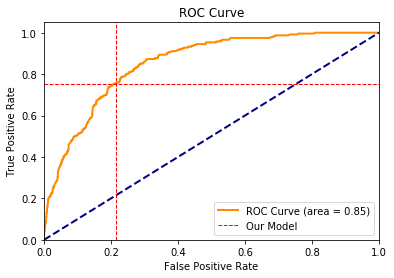

In [113]:
# Graphing the ROC curve for the validation data
plt.figure()
plt.plot(false_positive_rate, true_positive_rate, color='darkorange', lw=2,
         label='ROC Curve (area = {})'.format(round(roc_auc, 2)))
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
# plt.scatter(fpr, tpr, color='red')
plt.plot([fpr]*100, np.linspace(0, 1.05, 100), color='red', lw=1, linestyle='--', label='Our Model')
plt.plot(np.linspace(0, 1, 100), [tpr]*100, color='red', lw=1, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

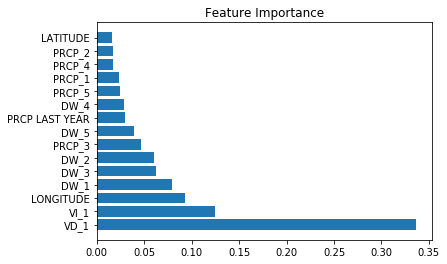

In [151]:
# Graphing the importance features
important_features = pd.DataFrame([model.feature_importances_], columns=X_train.columns, index=['Importance'])
important_features = important_features.T.sort_values('Importance', ascending=False)
plt.barh(important_features.index, important_features['Importance'])
plt.title('Feature Importance');

# Exporting the Model Predictions
### Creating the model prediction and true locations

In [76]:
# 2018 locations
predictions_2018 = test['2018'][y_hat_2018==1][['LATITUDE', 'LONGITUDE']]
real_2018 = test[test['RESULT']==1]['2018'][['LATITUDE', 'LONGITUDE']]

In [77]:
# 2017 locations
predictions_2017 = test['2017'][y_hat_2017==1][['LATITUDE', 'LONGITUDE']]
real_2017 = test[test['RESULT']==1]['2017'][['LATITUDE', 'LONGITUDE']]

In [78]:
# 2016 locations
predictions_2016 = test['2016'][y_hat_2016==1][['LATITUDE', 'LONGITUDE']]
real_2016 = test[test['RESULT']==1]['2016'][['LATITUDE', 'LONGITUDE']]

### Saving the locations to CSVs

In [79]:
# Commenting out to avoid accidental saves
# predictions_2018.to_csv('./assets/predictions_18')
# real_2018.to_csv('./assets/real_18')
# predictions_2017.to_csv('./assets/predictions_17')
# real_2017.to_csv('./assets/real_17')
# predictions_2016.to_csv('./assets/predictions_16')
# real_2016.to_csv('./assets/real_16')